In [17]:
from datetime import date
import math
from pathlib import Path
from collections import defaultdict
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import re
import webbrowser
from pytesseract import pytesseract
import json
import cv2
from transformers import AutoTokenizer, AutoModelWithLMHead
import seaborn as sns
import seaborn.objects as so
from matplotlib import pyplot as plt
import pandas as pd
from wordcloud import WordCloud

# Configuration variables
g_keywords = ["chinese", "japanese", "korean", "okinawan", "taiwanese", "tibetan", "\"east+asian\"", "oriental", "chinaman", "chinamen", "jap", "chink", "coolie", "celestial"]
g_search_date_range_start = date(1850, 1, 1)
g_search_date_range_end = date(2024, 7, 9)
g_num_articles_per_time_period = 20
g_time_block_range_years = 5

g_search_date_range_days = (g_search_date_range_end - g_search_date_range_start).days
g_num_time_blocks = math.ceil(g_search_date_range_days / (365 * g_time_block_range_years))

print("Number of time blocks: " + str(g_num_time_blocks))
print("Number of articles to download: " + str(g_num_time_blocks * g_num_articles_per_time_period))

def create_directories_if_do_not_exist(directories):
    for directory in directories:
        directory_path = Path.cwd() / directory
        if not directory_path.exists():
            directory_path.mkdir()
            print("Created directory: \"" + directory + "\"")

g_storage_directories = ["articles", "contexts", "uncorrected_contexts", "results"]
create_directories_if_do_not_exist(g_storage_directories)

g_time_block_number = int(input("Pick time block, 0-" + str(g_num_time_blocks - 1) + ": "))
if g_time_block_number < 0 or g_time_block_number >= g_num_time_blocks:
    print("Invalid time block!")
    exit()


def get_starting_date(time_block_num, search_date_range_start, time_block_range_years):
    return date(search_date_range_start.year + time_block_num * time_block_range_years, 1, 1)


def get_ending_date(time_block_num, search_date_range_start, search_date_range_end, time_block_range_years):
    ending_date = date(search_date_range_start.year + (time_block_num + 1) * time_block_range_years - 1, 12, 31)
    if ending_date > search_date_range_end:
        return search_date_range_end
    else:
        return ending_date


g_start_date = get_starting_date(g_time_block_number, g_search_date_range_start, g_time_block_range_years)
g_end_date = get_ending_date(g_time_block_number, g_search_date_range_start, g_search_date_range_end, g_time_block_range_years)

print("Start date: " + g_start_date.strftime('%Y-%m-%d'))
print("End date: " + g_end_date.strftime('%Y-%m-%d'))
print("Length of time period in days: " + str((g_end_date - g_start_date).days))

Number of time blocks: 35
Number of articles to download: 700
Start date: 1850-01-01
End date: 1854-12-31
Length of time period in days: 1825


Load functions

In [22]:
def parse_time_block_str(time_blocks_str):
    unprocessed_time_block_str_list = time_blocks_str.split(", ")
    time_block_list = []
    for time_block_str in unprocessed_time_block_str_list:
        if "-" in time_block_str:
            time_block_range = time_block_str.split("-")
            time_block_list.extend(range(int(time_block_range[0]), int(time_block_range[1]) + 1))
        else:
            time_block_list.append(int(time_block_str))
    return time_block_list


def get_time_block_number(year, search_date_range_start, time_block_range_years):
    return math.floor((year - search_date_range_start.year) / time_block_range_years)


def get_keywords_with_num_hits(keywords, start_date, end_date):
    keywords_with_num_hits = {}
    for keyword in keywords:
        webbrowser.open("https://www.newspapers.com/search/results/?country=us&date-end=" + end_date.strftime('%Y-%m-%d') + "&date-start=" + start_date.strftime('%Y-%m-%d') + "&entity-types=page&keyword=" + keyword)
        keywords_with_num_hits[keyword] = int(input("Number of hits: ").replace(",", ""))
    return keywords_with_num_hits


def get_keywords_with_num_articles(keywords_with_num_hits, num_articles_per_time_period):
    total_hits = sum(keywords_with_num_hits.values())
    article_remainders = []
    keywords_with_num_articles = {}
    for keyword, hits in keywords_with_num_hits.items():
        keywords_with_num_articles[keyword] = int((hits / total_hits) * num_articles_per_time_period)
        article_remainders.append((keyword, ((hits / total_hits) * num_articles_per_time_period) % 1))
    article_remainders.sort(key=lambda keyword_with_article_remainder: keyword_with_article_remainder[1], reverse=True)
    num_searches_short = num_articles_per_time_period - sum(keywords_with_num_articles.values())
    for i in range(num_searches_short):
        keywords_with_num_articles[article_remainders[i][0]] += 1
    return keywords_with_num_articles


def get_keywords_with_urls_and_num_articles(keywords_with_num_articles, start_date, end_date):
    keywords_with_urls_and_num_articles = []
    for keyword, num_articles in keywords_with_num_articles.items():
        keywords_with_urls_and_num_articles.append({
            "keyword": keyword,
            "url": "https://www.newspapers.com/search/results/?country=us&date-end=" + end_date.strftime('%Y-%m-%d') + "&date-start=" + start_date.strftime('%Y-%m-%d') + "&entity-types=page&keyword=" + keyword,
            "num_articles": num_articles
        })
    return keywords_with_urls_and_num_articles


def run_article_download_helper(keywords_with_urls_and_num_articles):
    for keyword_with_urls_and_num_articles in keywords_with_urls_and_num_articles:
        if keyword_with_urls_and_num_articles["num_articles"] != 0:
            text_input = input("Please download " + str(keyword_with_urls_and_num_articles["num_articles"]) + " articles with the keyword \"" + keyword_with_urls_and_num_articles["keyword"] + "\". Press return to continue. Type \"stop\" to stop.")
            if text_input == "stop":
                break
            webbrowser.open(keyword_with_urls_and_num_articles["url"])
            text_input = input("Once you have downloaded " + str(keyword_with_urls_and_num_articles["num_articles"]) + " articles with the keyword \"" + keyword_with_urls_and_num_articles["keyword"] + "\", press return to continue. Type \"stop\" to stop.")
            if text_input == "stop":
                break



def get_info_from_file_stem(file_stem):
    parts = file_stem.split('_')
    newspaper_name_parts = []

    for part in parts:
        if part.isdigit() and len(part) == 4:
            year_index = parts.index(part)
            break
        newspaper_name_parts.append(part)

    newspaper_name = ' '.join(newspaper_name_parts)
    date_published = date(int(parts[year_index]), int(parts[year_index + 1]), int(parts[year_index + 2]))

    return newspaper_name, date_published


def write_time_period_sorted_info_to_files(contexts, target_dir_path):
    if not target_dir_path.exists():
        target_dir_path.mkdir()
    for time_period, time_period_info in contexts.items():
        with open(target_dir_path / f"{time_period}.json", 'w+') as time_period_info_file:
            json.dump(time_period_info, time_period_info_file, indent=4)


def get_average_by_time_period(info_type, results_dir_path):
    average_by_time_period = {}
    for result_by_time_period_path in results_dir_path.rglob("*"):
        time_period = result_by_time_period_path.stem
        with open(result_by_time_period_path) as result_file:
            result_by_time_period = json.load(result_file)
            values = []
            for keyword, keyword_contexts in result_by_time_period.items():
                for keyword_context in keyword_contexts:
                    values.append(keyword_context[info_type])
            average_by_time_period[time_period] = sum(values) / len(values)
    return average_by_time_period


def get_combined_frequencies_by_time_period_excluding_keywords(info_type, results_dir_path):
    def add_frequency_dictionaries(dict1, dict2):
        combined_dict = dict(dict1)
        for key, value in dict2.items():
            if key not in g_keywords:
                if key in combined_dict:
                    combined_dict[key] += value
                else:
                    combined_dict[key] = value
        return combined_dict


    combined_frequency_by_time_period = {}
    for result_by_time_period_path in results_dir_path.rglob("*"):
        time_period = result_by_time_period_path.stem
        with open(result_by_time_period_path) as result_file:
            result_by_time_period = json.load(result_file)
            combined_frequency = defaultdict(int)
            for keyword, keyword_contexts in result_by_time_period.items():
                for keyword_context in keyword_contexts:
                    if isinstance(keyword_context[info_type], str) and keyword_context[info_type] not in g_keywords:
                        combined_frequency[keyword_context[info_type]] += 1
                    else:
                        combined_frequency = add_frequency_dictionaries(combined_frequency, keyword_context[info_type])
            combined_frequency_by_time_period[time_period] = combined_frequency
    return combined_frequency_by_time_period


def generate_word_clouds(word_frequencies_by_time_period):
    for time_period, word_frequencies in word_frequencies_by_time_period.items():
        word_cloud = WordCloud().generate_from_frequencies(word_frequencies)
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

Get the number of articles needed for each keyword by pasting in the number of hits for each keyword

In [4]:
g_keywords_with_num_articles = get_keywords_with_num_articles(get_keywords_with_num_hits(g_keywords, g_start_date, g_end_date), g_num_articles_per_time_period)
print(g_keywords_with_num_articles)

ValueError: invalid literal for int() with base 10: ''

Generate the URLs to grab the articles from. Note: number of URLs is not necessarily equal to number of articles to download.

In [5]:
g_keywords_with_urls_and_num_articles = get_keywords_with_urls_and_num_articles(g_keywords_with_num_articles, g_start_date, g_end_date)
print("Generated " + str(len(g_keywords_with_urls_and_num_articles)) + " URLs")

NameError: name 'g_keywords_with_num_articles' is not defined

Utility to guide users in downloading articles. Place articles in a folder with the same name as the keyword, which will be in the "articles" folder. Name the file with the date in the format "YYYY-MM-DD"

In [5]:
run_article_download_helper(g_keywords_with_urls_and_num_articles)

Load NLP

In [19]:
nlp_sentence_segmentation = spacy.load("en_core_web_trf")
nlp_sentiment_analysis = spacy.load("en_core_web_trf")
nlp_sentiment_analysis.add_pipe("spacytextblob")

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")


# Taken from https://huggingface.co/mrm8488/t5-base-finetuned-emotion
def get_emotion(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')
  output = model.generate(input_ids=input_ids, max_length=2)
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return str(label).replace("<pad> ", "")


def get_all_contexts_for_keywords(articles_dir_path, time_period_list):
    keywords_with_contexts_by_time_period = {}
    for time_period in time_period_list:
        keywords_with_contexts_by_time_period[time_period] = {}
        time_period_dir_path = articles_dir_path / str(time_period)
        for articles_by_keyword_dir_path in time_period_dir_path.rglob("*"):
            if articles_by_keyword_dir_path.is_dir():
                keyword = articles_by_keyword_dir_path.name
                keywords_with_contexts_by_time_period[time_period][keyword] = []
                for article_path in articles_by_keyword_dir_path.rglob("*"):
                    if article_path.is_file():
                        newspaper_name, date = get_info_from_file_stem(article_path.stem)
                        img = cv2.imread(article_path, cv2.IMREAD_GRAYSCALE)
                        blur = cv2.GaussianBlur(img,(5, 5), 0)
                        th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                        text = pytesseract.image_to_string(th3)
                        cleaned_text = cleaned_text = re.sub(r'\s+', ' ', text.replace(" |", "").replace("|", "").replace("-\n", "").replace("\n", " "))
                        keywords_with_contexts_by_time_period[time_period][keyword].append({
                            "newspaper": newspaper_name,
                            "date": date.strftime('%Y-%m-%d'),
                            "keyword": keyword,
                            "text": cleaned_text
                        })
    return keywords_with_contexts_by_time_period


def run_analysis_from_contexts(time_period_list, contexts_dir_path):
    keywords_with_contexts_and_analysis_by_time_period = {}
    for time_block_number in time_period_list:
        keywords_with_contexts_and_analysis_by_time_period[time_block_number] = {}
        with open(contexts_dir_path / f"{time_block_number}.json") as contexts_file:
            keywords_with_contexts = json.load(contexts_file)
            for keyword, contexts in keywords_with_contexts.items():
                keywords_with_contexts_and_analysis_by_time_period[time_block_number][keyword] = []
                for context in contexts:
                    doc = nlp_sentiment_analysis(context['text'])
                    word_frequency = defaultdict(int)
                    for token in doc:
                        if token.is_alpha and not token.is_stop:
                            word_frequency[token.text.lower()] += 1
                    context['polarity'] = doc._.blob.polarity
                    context['subjectivity'] = doc._.blob.subjectivity
                    context['word_frequency'] = word_frequency
                    context['emotion'] = get_emotion(context['text'])
                    keywords_with_contexts_and_analysis_by_time_period[time_block_number][keyword].append(context)
    return keywords_with_contexts_and_analysis_by_time_period

/Users/christopher/Documents/DataspellProjects/american-print-narratives-of-east-asians/.venv/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:1731: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Get contexts surrounding keywords with OCR and sentence segmentation. Provide a list of numbers (e.g. 1, 2, 3) and/or a range (e.g. 10-15). Write to file in all_contexts

In [7]:
g_articles_dir_path = Path.cwd() / 'articles'
write_time_period_sorted_info_to_files(get_all_contexts_for_keywords(g_articles_dir_path, parse_time_block_str(input("Enter time periods. Provide a list of numbers (e.g. 1, 2, 3) and/or a range (e.g. 10-15)."))), Path.cwd() / 'uncorrected_contexts')

Read in contexts from JSON file for analysis, perform and output to results

In [20]:
write_time_period_sorted_info_to_files(run_analysis_from_contexts(parse_time_block_str(input("Enter time periods for sentiment analysis. Provide a list of numbers (e.g. 1, 2, 3) and/or a range (e.g. 10-15).")), Path.cwd() / 'contexts'), Path.cwd() / 'results')

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


Compile and display data

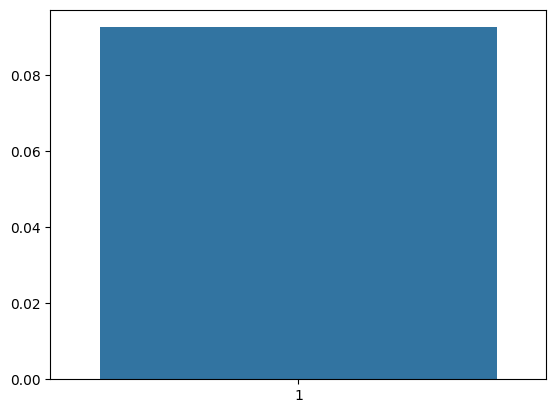

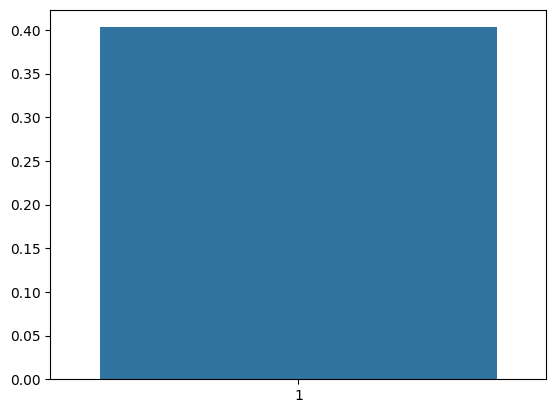

ValueError: Could not interpret value `time_period` for `x`. An entry with this name does not appear in `data`.

In [27]:
average_polarity_by_time_period = get_average_by_time_period('polarity', Path.cwd() / 'results')
sns.barplot(average_polarity_by_time_period)
plt.show()

average_subjectivity_by_time_period = get_average_by_time_period('subjectivity', Path.cwd() / 'results')
sns.barplot(average_subjectivity_by_time_period)
plt.show()

combined_emotion_frequencies_by_time_period = pd.DataFrame(get_combined_frequencies_by_time_period_excluding_keywords('emotion', Path.cwd() / 'results'))
# Plot dataframe with a stacked bar chart
so.barplot(data=combined_emotion_frequencies_by_time_period, stacked=True)

combined_word_frequencies_by_time_period = get_combined_frequencies_by_time_period_excluding_keywords('word_frequency', Path.cwd() / 'results')
generate_word_clouds(combined_word_frequencies_by_time_period)

